# header

In [1]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
'''

from google.colab import drive
from os import chdir

drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Gproject/MIT_glyco'
chdir(project_path)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np

import os
from os.path import exists
print(os.getcwd()) # current working directory

update = False

/content/drive/MyDrive/Gproject/MIT_glyco


In [3]:
load_name = "./data/data_for_ml.csv"
protein_list = list(pd.read_csv(load_name).protein.unique())
protein_augmented = [name for name in protein_list if exists(f'./data/data_for_ml(augmented)/{name}.csv')]

dataset = []
for name in protein_augmented:
    load_path = f'./data/data_for_ml(augmented)/{name}.csv'
    dataset.append(pd.read_csv(load_path))
dataset = pd.concat(dataset, axis=0).reset_index(drop=True)
dataset = dataset[(dataset['SEQ']=='S') | (dataset['SEQ']=='T')].reset_index(drop=True)

positive = dataset[dataset['positivity']==1]
negative = dataset[dataset['positivity']==0]

print("total number of proteins:          ", len(protein_list))
print("total number of augmented proteins:", len(protein_augmented))
print("total number of positive sites:    ", len(positive))

total number of proteins:           272
total number of augmented proteins: 89
total number of positive sites:     185


## parameter settings

In [4]:
from src.Data import *
from src.Preprocessing import *
from src.models import *

variables = xy_variables()
test_size = 0.2
valid_size = test_size/(1-test_size)

import random
random_state = 1
n_cv = 20

hpo_counts = 30
hpo_config = {
    "n_layers" : range(1,11),
    "n_neurons" : [16, 32, 64, 128, 256]
}
metrics = ['n_layers', 'n_neurons', 'epoch', 'time', 'loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1']
method = "random"

# model

In [5]:
model_name = 'augmented_mlp_window'
x_charge = pd.read_csv('./data/from_Krishna/features-all-names.csv').name.to_list()[:-1]

x_cts   = variables.x_cts_window + x_charge
x_cat   = variables.x_cat_window
y_label = variables.y_label

print(f"{len(x_cts)} x_cts:")
print(f"{len(x_cat)} x_cat: {x_cat}")
print(f"{len(y_label)} y_label: {y_label}")

data_x, data_y = df_to_dummy(dataset, x_cts, x_cat, y_label)
display(dict(zip(range(len(data_x.columns)), data_x.columns)))

159 x_cts:
12 x_cat: ['SEQ', 'nS/nT', 'nAli', 'nPos', 'phi_psi', 'SS', 'side_-1', 'side_1', 'side_2', 'side_3', 'side_4', 'side_5']
1 y_label: ['positivity']
dummy x shape: (8910, 237)
dummy y shape: (8910, 1)


{0: 'Proline',
 1: 'flexibility',
 2: '#',
 3: 'residue_SER_THR',
 4: 'number_of_hydrophobic',
 5: 'number_of_hydrophilic',
 6: 'number_of_polar',
 7: 'number_of_aromatic',
 8: 'number_of_aliphatic',
 9: 'number_of_charged',
 10: 'number_of_positive',
 11: 'number_of_negative',
 12: 'number_of_g',
 13: 'number_of_v',
 14: 'number_of_s',
 15: 'number_of_n',
 16: 'number_of_l',
 17: 'number_of_p',
 18: 'number_of_A',
 19: 'number_of_b',
 20: 'number_of_d',
 21: 'number_of_e',
 22: 'number_of_f',
 23: 'number_of_ala',
 24: 'number_of_cys',
 25: 'number_of_asp',
 26: 'number_of_glu',
 27: 'number_of_phe',
 28: 'number_of_his',
 29: 'number_of_ile',
 30: 'number_of_lys',
 31: 'number_of_leu',
 32: 'number_of_met',
 33: 'number_of_asn',
 34: 'number_of_gln',
 35: 'number_of_arg',
 36: 'number_of_ser',
 37: 'number_of_thr',
 38: 'number_of_val',
 39: 'number_of_trp',
 40: 'number_of_tyr',
 41: 'sasa_hydrophobic',
 42: 'sasa_hydrophilic',
 43: 'sasa_polar',
 44: 'sasa_aromatic',
 45: 'sasa_ali

## cross validation

In [6]:
# select n_layers and n_neurons as the best values of HPO
n_layers = 5
n_neurons = 100
cv_path = f'./result/cv_result_{model_name}_{n_layers}_{n_neurons}_{n_cv}.csv'

cv_result = pd.DataFrame([], columns=metrics)
if not exists(cv_path) or update:
    for i in range(n_cv):
        print(f"\n{i+1}th iteration")
        random.seed(i+1)
        train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                              test_size=test_size, random_state=i+1, 
                                                              scale_x=x_cts, scale_y=[])
        train_x, train_y = up_sampling(train_x, train_y)

        x_dim = train_x.shape[1]
        y_dim = train_y.shape[1]
        save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

        model = MLP(x_dim, y_dim)
        model.build(n_layers, n_neurons)
        if not exists(save_path) or update:
            model.train(train_x, train_y, valid_data=[test_x, test_y], save_path=save_path, verbose=2)
        else:
            model.load_model(save_path)

        epoch = model.epoch
        time = model.time
        loss = model.loss
        val_loss = model.val_loss
        test_loss, accuracy, precision, recall, f1 = model.evaluate(test_x, test_y)
        cv = pd.DataFrame([[n_layers, n_neurons, epoch, time, loss, val_loss, test_loss, accuracy, 
                             precision[1], recall[1], f1[1]]], columns=metrics)
        cv_result = pd.concat([cv_result, cv], axis=0)
    cv_result = cv_result.reset_index(drop=True)
    cv_result.to_csv(cv_path, index=False)    
    
else:
    cv_result = pd.read_csv(cv_path)

display(cv_result)


1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.04063701263042285 1.1368831455094939
up-sampled train dataset: (13960, 237) (13960, 1)
Epoch 1/10000
437/437 - 4s - loss: 0.5867 - accuracy: 0.6859 - val_loss: 0.5493 - val_accuracy: 0.7093 - 4s/epoch - 10ms/step
Epoch 2/10000
437/437 - 2s - loss: 0.5519 - accuracy: 0.7164 - val_loss: 0.6301 - val_accuracy: 0.6504 - 2s/epoch - 4ms/step
Epoch 3/10000
437/437 - 2s - loss: 0.5450 - accuracy: 0.7194 - val_loss: 0.4676 - val_accuracy: 0.7666 - 2s/epoch - 4ms/step
Epoch 4/10000
437/437 - 2s - loss: 0.5393 - accuracy: 0.7223 - val_loss: 0.4745 - val_accuracy: 0.7615 - 2s/epoch - 4ms/step
Epoch 5/10000
437/437 - 1s - loss: 0.5392 - accuracy: 0.7212 - val_loss: 0.4207 - val_accuracy: 0.7884 - 1s/epoch - 3ms/step
Epoch 6/10000
437/437 - 2s - loss: 0.5348 - accuracy: 0.7237 - val_loss: 0.6953 - val_accuracy: 0.6150 - 2s/epoch - 4ms/step
Epoch 7

,n_layers,n_neurons,epoch,time,loss,val_loss,test_loss,accuracy,precision,recall,f1
0,5,100,4,1.157,0.539239,0.420678,0.420678,78.84,4.79,48.65,8.72
1,5,100,34,2.014,0.494019,0.410764,0.410764,82.10,5.94,51.35,10.64
2,5,100,2,0.884,0.530531,0.414620,0.414620,81.14,4.28,37.84,7.69
3,5,100,14,1.257,0.500691,0.421532,0.421532,79.69,4.48,43.24,8.12
4,5,100,1,1.093,0.539478,0.366320,0.366320,87.15,5.14,29.73,8.76
5,5,100,0,0.961,0.580270,0.337899,0.337899,88.78,4.97,24.32,8.26
6,5,100,4,1.158,0.511751,0.421710,0.421710,79.69,5.23,51.35,9.50
7,5,100,11,1.218,0.484208,0.333140,0.333140,85.69,3.81,24.32,6.59
8,5,100,8,1.112,0.531150,0.389250,0.389250,82.66,5.84,48.65,10.43
9,5,100,2,0.850,0.537350,0.385705,0.385705,83.28,5.76,45.95,10.24



1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.04063701263042285 1.1368831455094939
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_1of20.h5


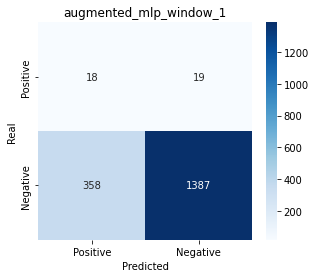

accuracy  : 78.84
precision : [98.65  4.79]
recall    : [79.48 48.65]
f1_score  : [88.04  8.72]

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.053209459459459374 1.4285714285714286
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_2of20.h5


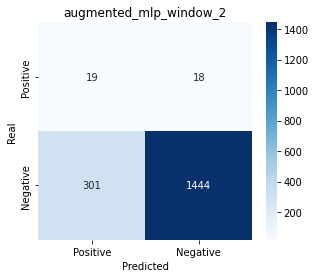

accuracy  : 82.1
precision : [98.77  5.94]
recall    : [82.75 51.35]
f1_score  : [90.05 10.64]

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.010150622134905045 1.1428571428571428
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_3of20.h5


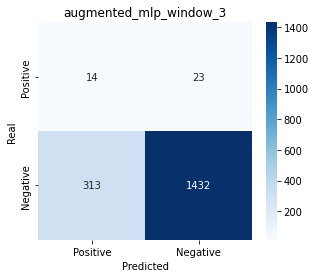

accuracy  : 81.14
precision : [98.42  4.28]
recall    : [82.06 37.84]
f1_score  : [89.5   7.69]

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.04063701263042285 1.3335864392504608
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_4of20.h5


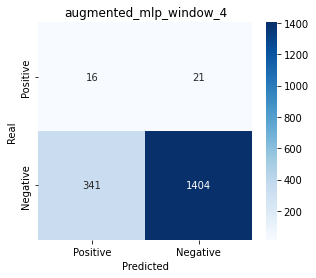

accuracy  : 79.69000000000001
precision : [98.53  4.48]
recall    : [80.46 43.24]
f1_score  : [88.58  8.12]

5th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.05361702127659566 1.2857142857142858
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_5of20.h5


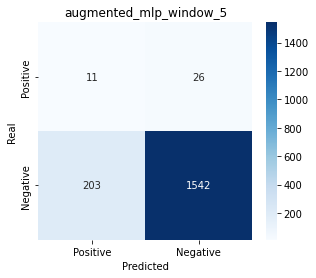

accuracy  : 87.15
precision : [98.34  5.14]
recall    : [88.37 29.73]
f1_score  : [93.09  8.76]

6th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.03435948361469706 1.4285714285714286
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_6of20.h5


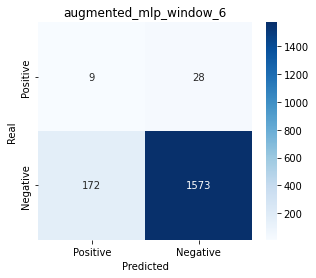

accuracy  : 88.78
precision : [98.25  4.97]
recall    : [90.14 24.32]
f1_score  : [94.02  8.26]

7th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.08261159227181879 1.5714285714285714
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_7of20.h5


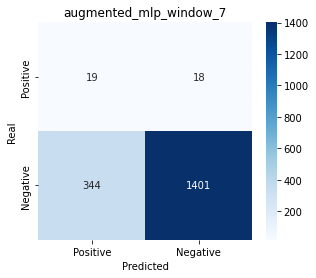

accuracy  : 79.69000000000001
precision : [98.73  5.23]
recall    : [80.29 51.35]
f1_score  : [88.56  9.5 ]

8th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.07051046204631907 1.375
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_8of20.h5


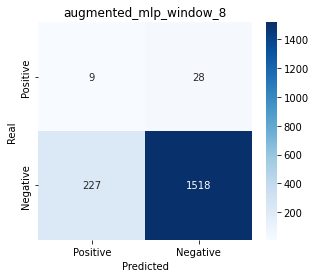

accuracy  : 85.69
precision : [98.19  3.81]
recall    : [86.99 24.32]
f1_score  : [92.25  6.59]

9th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.042349728369226396 1.1875
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_9of20.h5


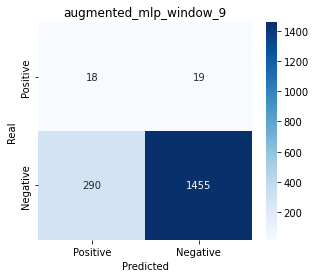

accuracy  : 82.66
precision : [98.71  5.84]
recall    : [83.38 48.65]
f1_score  : [90.4  10.43]

10th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.08623693379790943 1.375
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_10of20.h5


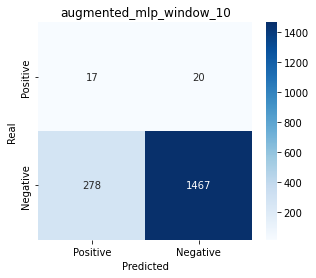

accuracy  : 83.28
precision : [98.66  5.76]
recall    : [84.07 45.95]
f1_score  : [90.78 10.24]

11th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.053209459459459374 1.4285714285714286
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_11of20.h5


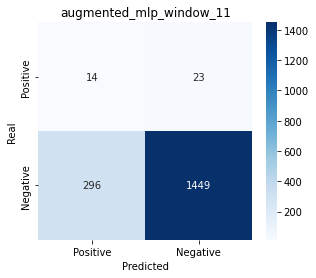

accuracy  : 82.1
precision : [98.44  4.52]
recall    : [83.04 37.84]
f1_score  : [90.08  8.07]

12th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.011059617605329954 1.1727418098995832
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_12of20.h5


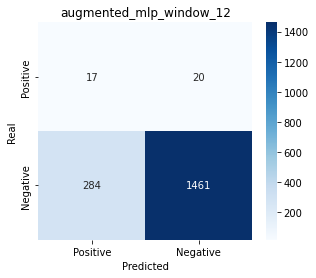

accuracy  : 82.94
precision : [98.65  5.65]
recall    : [83.72 45.95]
f1_score  : [90.58 10.06]

13th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.053209459459459374 1.2727272727272727
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_13of20.h5


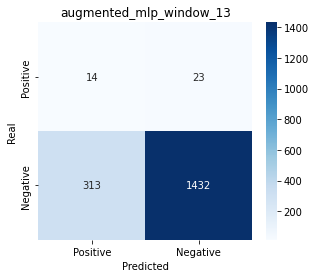

accuracy  : 81.14
precision : [98.42  4.28]
recall    : [82.06 37.84]
f1_score  : [89.5   7.69]

14th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.026315789473684126 1.4175599920352342
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_14of20.h5


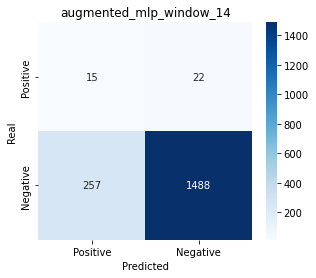

accuracy  : 84.34
precision : [98.54  5.51]
recall    : [85.27 40.54]
f1_score  : [91.43  9.71]

15th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.07172207301241755 1.215472902678131
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_15of20.h5


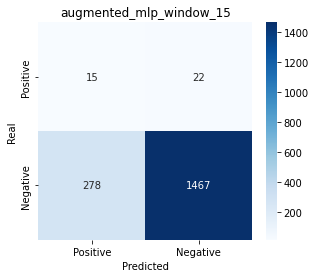

accuracy  : 83.16
precision : [98.52  5.12]
recall    : [84.07 40.54]
f1_score  : [90.72  9.09]

16th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.04063701263042285 1.1428571428571428
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_16of20.h5


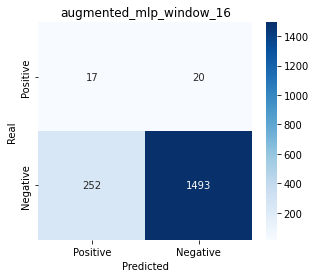

accuracy  : 84.74000000000001
precision : [98.68  6.32]
recall    : [85.56 45.95]
f1_score  : [91.65 11.11]

17th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.03758542141230069 1.215472902678131
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_17of20.h5


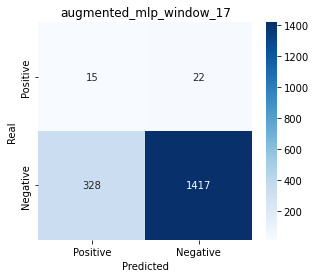

accuracy  : 80.36
precision : [98.47  4.37]
recall    : [81.2  40.54]
f1_score  : [89.01  7.89]

18th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.03435948361469706 1.2465688648193187
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_18of20.h5


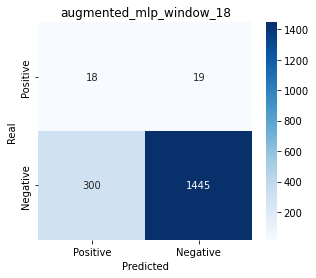

accuracy  : 82.1
precision : [98.7   5.66]
recall    : [82.81 48.65]
f1_score  : [90.06 10.14]

19th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.08261159227181879 1.5714285714285714
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_19of20.h5


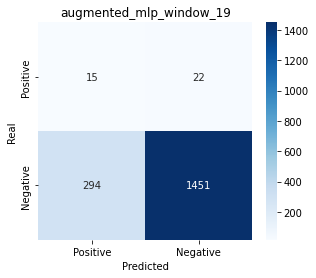

accuracy  : 82.27
precision : [98.51  4.85]
recall    : [83.15 40.54]
f1_score  : [90.18  8.67]

20th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 237) (7128, 1)
check scale: 0.0 1.0

test: (1782, 237) (1782, 1)
check scale: -0.007340674007340755 1.375
up-sampled train dataset: (13960, 237) (13960, 1)
model has been restored from ./h5/augmented_mlp_window_5_100_cv_20of20.h5


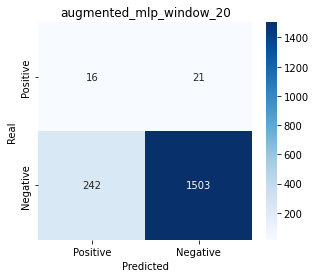

accuracy  : 85.24000000000001
precision : [98.62  6.2 ]
recall    : [86.13 43.24]
f1_score  : [91.95 10.85]


In [7]:
from src.graph_plot import *

for i in range(n_cv):
    print(f"\n{i+1}th iteration")
    random.seed(i+1)
    train_x, train_y, test_x, test_y, _, _ = stratified_split(data_x, data_y, 
                                                          test_size=test_size, random_state=i+1, 
                                                          scale_x=x_cts, scale_y=[])
    train_x, train_y = up_sampling(train_x, train_y)

    x_dim = train_x.shape[1]
    y_dim = train_y.shape[1]
    save_path  = f'./h5/{model_name}_{n_layers}_{n_neurons}_cv_{i+1}of{n_cv}.h5'

    model = MLP(x_dim, y_dim)
    model.build(n_layers, n_neurons)
    model.load_model(save_path)
    
    prediction = model.model.predict(test_x, verbose=0)
    y_pred = prediction.round(0).astype(int)
    y_real = test_y
    
    plot_confusion(y_real, y_pred, title=model_name+f"_{i+1}", label=["Positive","Negative"])